## INTRODUCTION
Based on the preliminary modules, we officially analyze and retrieve data from PumpOlymp's database of all pumps that happened since June 1st 2018

In [1]:
import pandas as pd 
import numpy as np
import json 
import requests 
import time  as sleeper
from datetime import datetime, date, time, timedelta
import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from mpl_finance import candlestick_ohlc
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.ticker as mticker
%load_ext autoreload

In [2]:
import os, sys
sys.path.append('../..') #Append the directory above to the path *verify levels*
import utils

### Import the historical data
.originally downloaded on 2019-09-01. 
But for final analyses we are using the latest file from PumpOlymp spreading from __06/2018__ to __12/2019__

In [3]:
dt = pd.read_json('../../allPumps_20200201.json')

In [4]:
dt.columns.values

array(['marketHistoryEntries', 'currency', 'exchange', 'channelTitle',
       'channelLink', 'max', 'priceBeforePump', 'duration', 'volume',
       'signalTime', 'ourBuyPrice', 'ourBuyTime', 'ourProfit',
       'theoreticalBuyPrice', 'theoreticalBuyTime', 'theoreticalProfit',
       'id'], dtype=object)

In [5]:
all_pumps = dt[['channelLink','channelTitle','currency','duration','exchange','priceBeforePump','signalTime']]
all_pumps = all_pumps.reset_index(drop=True)

In [6]:
all_pumps.head()

,channelLink,channelTitle,currency,duration,exchange,priceBeforePump,signalTime
0,https://t.me/crypto_pump_island,Crypto Pump Island,NAV,03:20,Binance,0.000012,2019-12-19T17:00:15
1,https://t.me/Bull_Signals_Strategies,Bull ⚡️ Signals,REN,00:21,Yobit,0.000005,2019-12-18T15:00:05
2,https://t.me/Bull_Signals_Strategies,Bull ⚡️ Signals,FTM,01:35,Yobit,0.000002,2019-12-14T14:00:04
3,https://t.me/crypto_family_new,CryptoFamily Binance / Bittrex,CURE,00:39,Bittrex,0.000006,2019-12-12T20:00:07.763
4,https://t.me/crypto_lions,Crypto Lion's™,DUSK,01:14,Binance,0.000006,2019-12-12T13:57:29


Append the edited Time and Timestamp

In [7]:
to_datetime = lambda x : datetime.strptime(x.replace('T',' ').replace('Z','')[:19]+' +0000',"%Y-%m-%d %H:%M:%S %z")
to_unix = lambda x: str(int(datetime.timestamp(x)))

In [8]:
all_pumps['pumptime_edited'] = all_pumps.signalTime.apply(lambda x : to_datetime(x))
all_pumps['timestamp'] = all_pumps.pumptime_edited.apply(to_unix)
all_pumps['event_date'] = all_pumps.pumptime_edited.apply(lambda x:x.date)
all_pumps['event_time'] = all_pumps.pumptime_edited.apply(lambda x:x.time)
all_pumps['pump_year'] = all_pumps.pumptime_edited.apply(lambda x:x.year)
all_pumps['pump_weekday'] = all_pumps.pumptime_edited.apply(lambda x: x.weekday)
all_pumps['pump_date'] = all_pumps.pumptime_edited.apply(lambda x: x.day)
#Pump hour ignores the minutes in this iteration
all_pumps['pump_hour'] = all_pumps.pumptime_edited.apply(lambda x: x.hour)
all_pumps['pump_minute'] = all_pumps.pumptime_edited.apply(lambda x: x.minute)

In [9]:
all_pumps.head() 

,channelLink,channelTitle,currency,duration,exchange,priceBeforePump,signalTime,pumptime_edited,timestamp,event_date,event_time,pump_year,pump_weekday,pump_date,pump_hour,pump_minute
0,https://t.me/crypto_pump_island,Crypto Pump Island,NAV,03:20,Binance,0.000012,2019-12-19T17:00:15,2019-12-19 17:00:15+00:00,1576774815,2019-12-19,17:00:15,2019,3,19,17,0
1,https://t.me/Bull_Signals_Strategies,Bull ⚡️ Signals,REN,00:21,Yobit,0.000005,2019-12-18T15:00:05,2019-12-18 15:00:05+00:00,1576681205,2019-12-18,15:00:05,2019,2,18,15,0
2,https://t.me/Bull_Signals_Strategies,Bull ⚡️ Signals,FTM,01:35,Yobit,0.000002,2019-12-14T14:00:04,2019-12-14 14:00:04+00:00,1576332004,2019-12-14,14:00:04,2019,5,14,14,0
3,https://t.me/crypto_family_new,CryptoFamily Binance / Bittrex,CURE,00:39,Bittrex,0.000006,2019-12-12T20:00:07.763,2019-12-12 20:00:07+00:00,1576180807,2019-12-12,20:00:07,2019,3,12,20,0
4,https://t.me/crypto_lions,Crypto Lion's™,DUSK,01:14,Binance,0.000006,2019-12-12T13:57:29,2019-12-12 13:57:29+00:00,1576159049,2019-12-12,13:57:29,2019,3,12,13,57


In [10]:
#There is 1 noise pump at 1999. Eliminate it. 
all_pumps = all_pumps[all_pumps.pump_year != 1999]

__NOTE__: manually verify the timestamp to make sure that it is the correct __UTC__ representation

In [11]:
all_pumps.pumptime_edited.describe()

count                           885
unique                          879
top       2018-12-16 17:00:03+00:00
freq                              2
first     2018-06-17 18:15:29+00:00
last      2019-12-19 17:00:15+00:00
Name: pumptime_edited, dtype: object

In [12]:
all_pumps.shape

(885, 16)

In [13]:
all_pumps.to_pickle('../all_pumps.pkl')

## Preliminary Analysis 

## Through time

/Users/hn/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning:

Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()



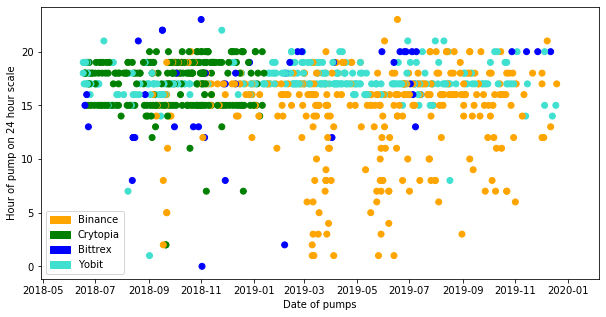

In [14]:
import matplotlib.patches as mpatches
color_dct = {"Binance":"orange","Cryptopia":"green","Bittrex":"blue","Yobit":"turquoise"}
exchange_fig = plt.figure(figsize=(10,5))
plt.scatter(all_pumps.event_date, all_pumps.pump_hour
            ,c=all_pumps.exchange.apply(lambda x:color_dct[x])
            )
plt.xlabel("Date of pumps")
plt.ylabel("Hour of pump on 24 hour scale")
#Legend
orange_patch = mpatches.Patch(color='orange', label='Binance')
green_patch = mpatches.Patch(color='green', label='Crytopia')
blue_patch = mpatches.Patch(color='blue', label='Bittrex')
turquoise_patch = mpatches.Patch(color='turquoise', label='Yobit')
plt.legend(handles=[orange_patch,green_patch,blue_patch,turquoise_patch])
plt.show()

### Exchanges

In [15]:
all_pumps.groupby('exchange').exchange.count()

exchange
Binance      324
Bittrex       49
Cryptopia    243
Yobit        269
Name: exchange, dtype: int64

In [16]:
#Investigating coins on Binance
b_coins = all_pumps[all_pumps.exchange == 'Binance']
b_coins.currency.drop_duplicates().count()

108

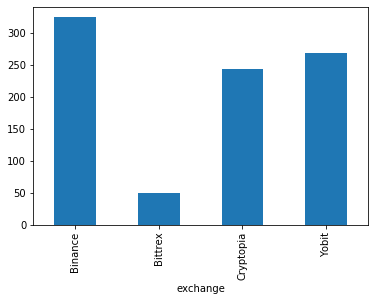

In [17]:
all_pumps.groupby('exchange').exchange.count().plot(kind='bar')

### Weekday

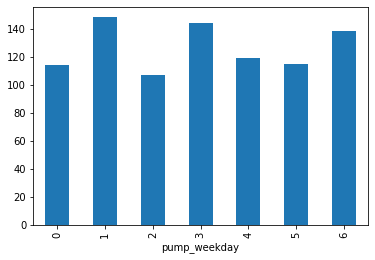

In [18]:
all_pumps.groupby('pump_weekday').pump_weekday.count().plot(kind='bar')

### Day of Month

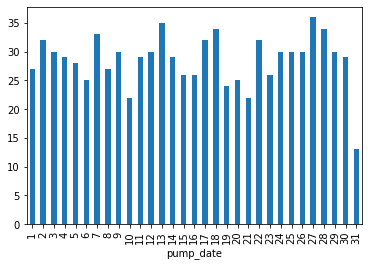

In [19]:
all_pumps.groupby('pump_date').pump_date.count().plot(kind='bar')

### Hour

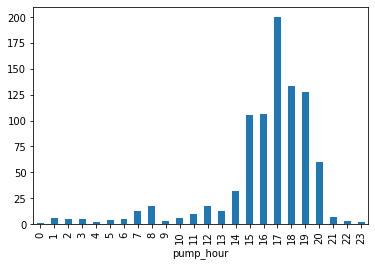

In [20]:
all_pumps.groupby('pump_hour').pump_hour.count().plot(kind='bar')

### Unique Coins

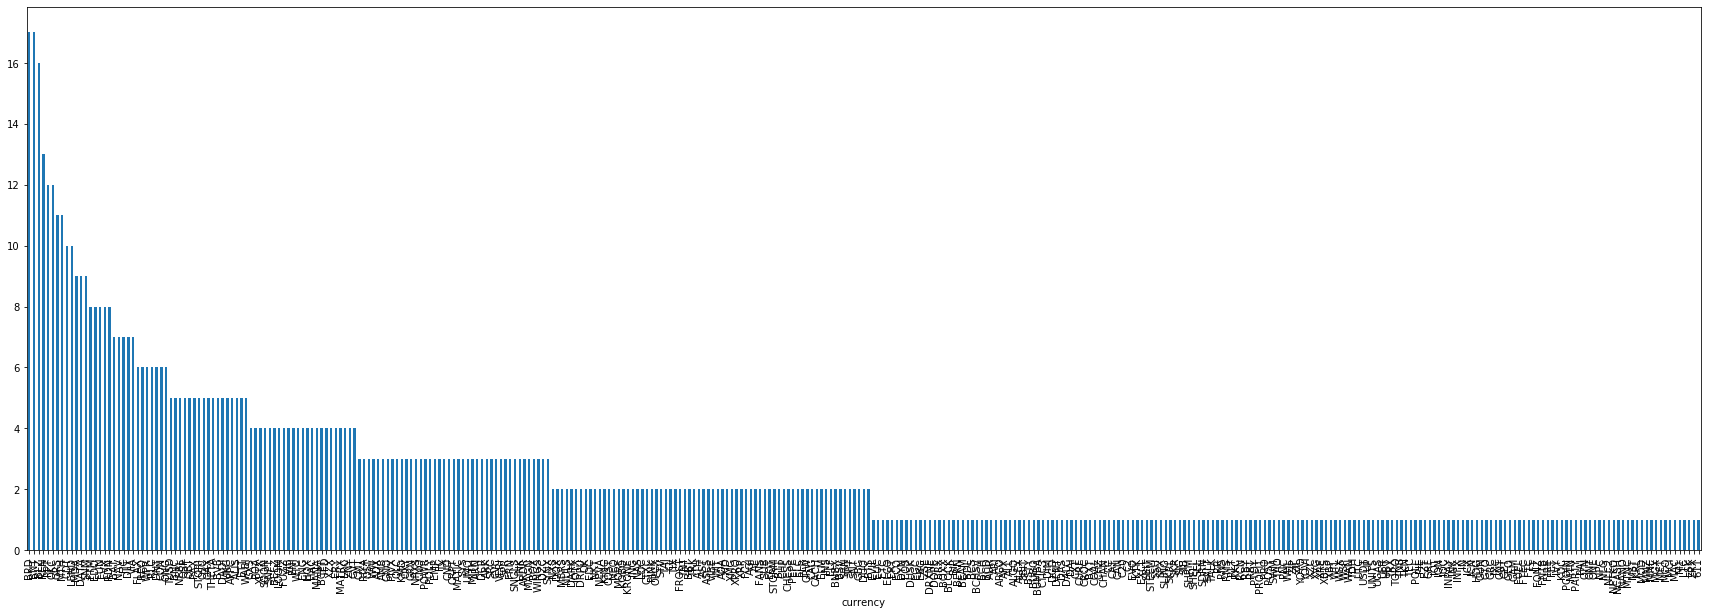

In [21]:
all_pumps.groupby('currency').currency.count().sort_values(ascending=False).plot(kind='bar', figsize=(30,10))

In [22]:
print('There are {} unique currencies/coin in this dataset'.format(all_pumps.currency.drop_duplicates().count()))

There are 355 unique currencies/coin in this dataset


...But some coins will appear and be pumped at exchanges

# DERIVE THE UNIQUE COINS AND EXCHANGES AS TEMPLATE LATER

In [23]:
coin_list = all_pumps[['currency','exchange']].drop_duplicates()
coin_list.head(2)

,currency,exchange
0,NAV,Binance
1,REN,Yobit


Also add the coin_ID to retrieve social media to append late. 
Use the Cryptocompare API to download and save the all_coins_xxxx.json file, where we can get the ID and names of coin to be used later.m

In [24]:
with open("../../coinlist_022020.json","r") as j: 
    coin_info = json.load(j)

In [25]:
pd.DataFrame(coin_info['Data'].values()).to_pickle("../../all_coins_info.pkl")

In [26]:
all_coins_info = pd.read_pickle('../../all_coins_info.pkl')

In [27]:
all_coins_info.head(3)
# print(all_coins_info.columns)
print("CrytoCompare API at this time contains",all_coins_info.Id.drop_duplicates().count(),"coins")

CrytoCompare API at this time contains 4445 coins


In [28]:
coin_list = pd.merge(left=coin_list,left_on='currency',right=all_coins_info[['Symbol','Id']],right_on='Symbol',how='left').drop('Symbol',axis=1)

__NOTE__: There are coins with no lookupable CryptoMarket data, signififed NaN ID. 

In [29]:
na_coin = coin_list[coin_list.Id.isnull()].currency.drop_duplicates().count()
print("There are",na_coin,"without ID.")

There are 49 without ID.


In [30]:
coin_list.to_pickle('../../Coin_Data/coin_list.pkl')

Must always save this as coin_list in the Coin_Data folder!!!!!!

__NOW WE ARE READY TO DOWNLOAD THE HOURLY AND DAILY COIN DATA from 2018-06-01 to 2019-08-31!!!!!__

In [31]:
coin_list.head()

,currency,exchange,Id
0,NAV,Binance,4571
1,REN,Yobit,788239
2,FTM,Yobit,928158
3,CURE,Bittrex,5387
4,DUSK,Binance,928535


## Enhancement TO BINANCE ONLY DATA

We need to the final set that satisfies ALL of the following criteria:
    1. Available on Binance 
    2. Trading pair with BTC (Bitcoin available)
    3. Low market cap less than 50 millions 
    4. Date of pumped not overlapped within 3 days of any known pumped events.

## SELECT THE DATE

In [32]:
pt = all_pumps[all_pumps.exchange=="Binance"][["pumptime_edited","timestamp","event_date","event_time"]].drop_duplicates()

In [33]:
p_date = pd.to_datetime(pt.event_date)

In [34]:
print("There are {} unique dates".format(p_date.drop_duplicates().count()))

There are 220 unique dates


__NOTE__: WE CHOOSE DECEMBER 30th to allow some time cushion

In [35]:
all_date = pd.date_range(start="06/01/2018",end="12/30/2019")
len(all_date)

578

In [36]:
#Exclude everyday within 3 days before.
p_date_1 = p_date.apply(lambda x:x+timedelta(hours=24))
p_date_2 = p_date.apply(lambda x:x+timedelta(hours=48))
p_date_3 = p_date.apply(lambda x:x+timedelta(hours=72))

In [37]:
exclude = pd.concat([p_date,p_date_1,p_date_2,p_date_3],sort=True).drop_duplicates()
exclude.count()

419

In [38]:
#Get the list of dates 
extra_date = all_date[np.isin(all_date,exclude)==False]
len(extra_date)

159

In [39]:
extra_date = pd.DataFrame(extra_date,columns={"ext_dt"})
for i,r in extra_date.iterrows():
    extra_date.loc[i,"pumptime_edited"] = extra_date.loc[i,"ext_dt"] + timedelta(hours=np.random.randint(0,25))
#     print(r)

## PROCESSING COIN LIST

In [40]:
pump_bn = all_pumps[all_pumps.exchange=="Binance"][["currency", "exchange","signalTime","pumptime_edited"]]

In [41]:
pump_bn.drop_duplicates()

,currency,exchange,signalTime,pumptime_edited
0,NAV,Binance,2019-12-19T17:00:15,2019-12-19 17:00:15+00:00
4,DUSK,Binance,2019-12-12T13:57:29,2019-12-12 13:57:29+00:00
5,EDO,Binance,2019-12-08T21:01:51,2019-12-08 21:01:51+00:00
8,BEAM,Binance,2019-12-04T12:06:16,2019-12-04 12:06:16+00:00
9,CDT,Binance,2019-12-02T18:50:05,2019-12-02 18:50:05+00:00
...,...,...,...,...
722,GRS,Binance,2018-09-18T02:12:02,2018-09-18 02:12:02+00:00
735,ICN,Binance,2018-09-11T15:30:10,2018-09-11 15:30:10+00:00
738,DNT,Binance,2018-09-10T14:00:14,2018-09-10 14:00:14+00:00
748,GRS,Binance,2018-09-06T18:34:01,2018-09-06 18:34:01+00:00


In [42]:
#What are the coins we succesfully downloaded on Binance on Cryptocomare

In [43]:
bcoin = []
for filename in os.listdir("../../Coin_Data/Hourly"):
    if '.pkl'in filename and 'error' not in filename : 
        symbol = filename.split('_')[1]
        bcoin.append(symbol)
print("There are {} coins downloaded for Binance".format(len(bcoin)))
bcoin = pd.DataFrame({"coin_name":bcoin})
b_pump_coin = pump_bn.currency.drop_duplicates()
print("There are {} coins in our Binance pumped list".format(b_pump_coin.nunique()))

There are 124 coins downloaded for Binance
There are 108 coins in our Binance pumped list


In [44]:
#Test: do they overlap
print("There are {} coins downloaded but not pumped".format(len(list(set(bcoin) - set(b_pump_coin))) - 1))
# Thes are usually tokens, or forks of existing coins, not full cryptocurrencies

There are 0 coins downloaded but not pumped


In [45]:
#Test: do they overlap

print("There are {} coins pumped but not downloable".format(len(set(b_pump_coin) - set(bcoin) )))
# set(b_pump_coin) - set(bcoin)

There are 108 coins pumped but not downloable


In [46]:
## Crreat the new pump list as All Available Binance Coin x Pumped coin Data
true_pump = pump_bn.assign(key=1).merge(bcoin.assign(key=1))[["currency","exchange","pumptime_edited","coin_name"]]

In [47]:
true_pump.head(2)

,currency,exchange,pumptime_edited,coin_name
0,NAV,Binance,2019-12-19 17:00:15+00:00,VIB
1,NAV,Binance,2019-12-19 17:00:15+00:00,STEEM


In [48]:
## PROCESS FAKE PUMP
fake_pump = extra_date.assign(key=1).merge(bcoin.assign(key=1))[['pumptime_edited','coin_name']]
fake_pump["currency"] = '***'
fake_pump['exchange'] = 'Binance'
fake_pump['pumptime_edited'] = pd.to_datetime(fake_pump.pumptime_edited, utc=True)
fake_pump = fake_pump[['currency','exchange','pumptime_edited','coin_name']]

In [49]:
fake_pump.head(2)

,currency,exchange,pumptime_edited,coin_name
0,***,Binance,2018-06-01 12:00:00+00:00,VIB
1,***,Binance,2018-06-01 12:00:00+00:00,STEEM


## FINAl STACKED PUMP DATA

In [50]:
final_pumps = pd.concat([true_pump,fake_pump],axis=0).drop_duplicates()

Once again, append timestamp variables

In [51]:
final_pumps['timestamp'] = final_pumps.pumptime_edited.apply(to_unix)
final_pumps['event_date'] = final_pumps.pumptime_edited.apply(lambda x:x.date)
final_pumps['event_time'] = final_pumps.pumptime_edited.apply(lambda x:x.time)

In [53]:
final_pumps.shape

(59286, 7)

In [52]:
final_pumps.to_pickle('../all_pumps.pkl')

....NOW NAVIGATE TO MOD 1 AND COLELLECT THE TIME SERIES DATA...